In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold 
from sklearn import cluster 
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

import sys
sys.path.append('../scripts')
import utilities as ut

### Load preprocessed dataset from ../../../data/processed directory

In [248]:
df = pd.read_csv('../../../data/processed/steel_industry_data_preprocessed.csv')
df.head()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,NSM,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Usage_kWh_categorical
0,-0.055136,-0.022002,0.000000,0.0,-0.737075,-0.791667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.090582,-0.088238,0.000000,0.0,-0.661852,-0.645833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.090582,-0.114395,0.000000,0.0,-0.566321,-0.520833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.064784,-0.514621,3.717580,0.0,0.335216,-0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.059934,-0.514621,3.848314,0.0,0.335216,-0.125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             2190 non-null   float64
 1   Lagging_Current_Reactive_Power_kVarh  2190 non-null   float64
 2   Leading_Current_Reactive_Power_kVarh  2190 non-null   float64
 3   CO2                                   2190 non-null   float64
 4   Lagging_Current_Power_Factor          2190 non-null   float64
 5   NSM                                   2190 non-null   float64
 6   WeekStatus_Weekend                    2190 non-null   float64
 7   Day_of_week_Monday                    2190 non-null   float64
 8   Day_of_week_Saturday                  2190 non-null   float64
 9   Day_of_week_Sunday                    2190 non-null   float64
 10  Day_of_week_Thursday                  2190 non-null   float64
 11  Day_of_week_Tuesd

In [250]:
df_scaled = df.copy()
# drop column 'Usage_kWh_categorical'
df_scaled = df_scaled.drop(['Usage_kWh_categorical'], axis=1)

### Modelling - pipeline
### K-means clustering

### Determinig the optimal number of clusters using Elbow Method 

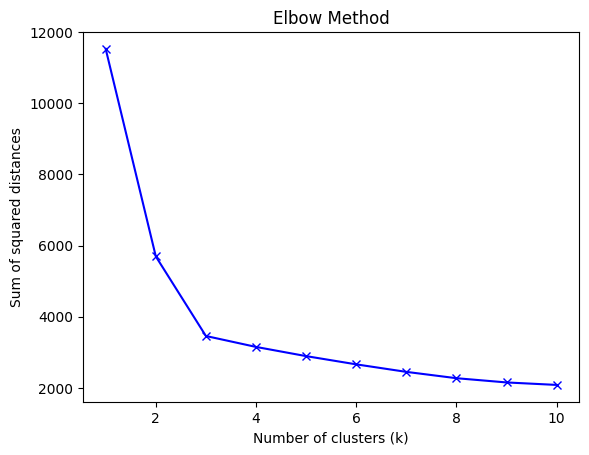

In [251]:
# Elbow method
# Sum of squared distances of samples to their closest cluster center.
inertias = []
k_values = range(1, 11)  # range of k values to try

for k in k_values:    
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    pipe = make_pipeline(kmeans)
    pipe.fit_predict(df_scaled)
    inertias.append(pipe[0].inertia_)

# Plotting the elbow curve
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

### Observation 
- From Elbow method, recommended optimal k value is 3. 
- Silhouette_score will be used to evaluate model



### Building pipeline for K=3

In [252]:
# since data is scaled, we can use k-means directly
pipe = make_pipeline(cluster.KMeans(n_clusters=3, n_init=10, max_iter=300))

In [253]:
pipe

Pipeline(steps=[('kmeans', KMeans(n_clusters=3, n_init=10))])

In [254]:
clusters = pipe.fit(df_scaled)

In [255]:
data_and_centers = np.r_[df_scaled,clusters[0].cluster_centers_]


### Apply multi-dimensional scaling(MDS) to project both data and k-Means cluster center to a 2D space

In [256]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


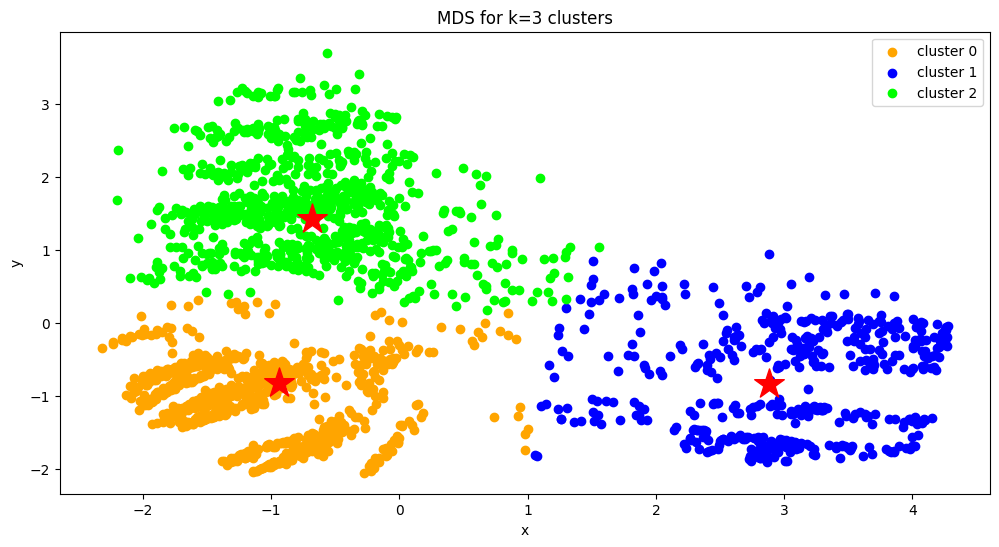

In [257]:
# Plotting the clusters
plt.figure(figsize=(12, 6))
k=3
ut.clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clusters[0].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS for k=3 clusters')

### Apply t-SNE to project both data and k-means cluster centers to a 2D space

In [258]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


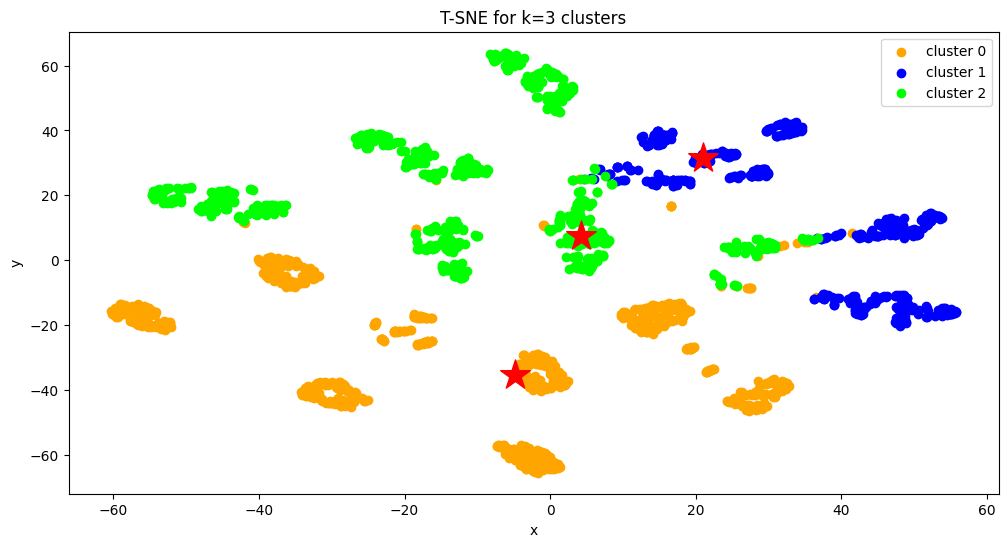

In [259]:
# Plotting the clusters
plt.figure(figsize=(12, 6))

k=3
ut.clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clusters[0].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='T-SNE for k=3 clusters')

### Evaluate our model with Silhouette_score

In [260]:
labels = clusters[0].labels_
silhouette_score(df, labels, metric='euclidean')

0.4657309086471142

### compare silhouette scores with baseline scores

In [261]:
## compare silhouette scores with baseline scores
n_samples = df_scaled.shape[0]

n_clusters = 3

random_labels = np.random.randint(0,n_clusters, size=n_samples)

# compute silhouette score for random labels
random_silhoutte_score = silhouette_score(df_scaled, random_labels, metric='euclidean')

random_silhoutte_score



-0.00915359316498519

### Observation

- Silhouette_score has been compared with baseline randomly assigned clusters. 
- Silhoutte_score for k=3 is significantly higher than baseline random clusters
- therefore, Silhouette score for k=3 is meaningful. 

However, we will also calculate silhoutte score for different number of clusters 

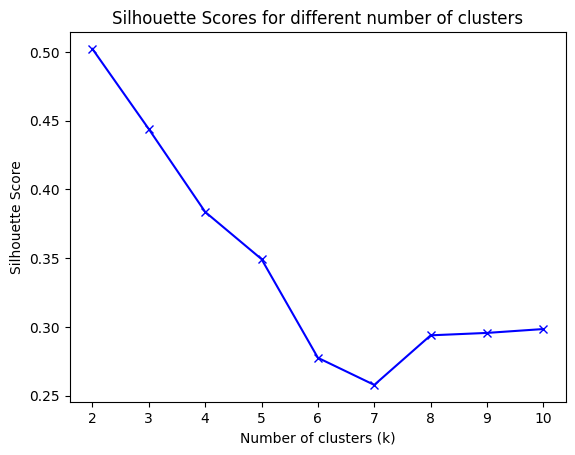

In [262]:
### compare silhouette scores for different number of clusters
silhouette_scores = []
k_values = range(2, 11)  # range of k values to try

for k in k_values:
    pipe = make_pipeline(cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
    clusters = pipe.fit(df_scaled)
    labels = clusters[0].labels_
    silhouette_scores.append(silhouette_score(df_scaled, labels, metric='euclidean'))

# Plotting the silhouette scores
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different number of clusters')
plt.show()


In [263]:
silhouette_scores[0]

0.5022232818251883

### Observation

- From the above graph, it is indicated that for k= 2, silhoutte score is 0.50 which is higher than for k = 3. 

### Building pipeline for K=2 

In [264]:
k2_pipe = make_pipeline(cluster.KMeans(n_clusters=2, n_init=10, max_iter=300))

In [265]:
k2_clusters = k2_pipe.fit(df_scaled)

In [266]:
k2_data_and_centers = np.r_[df_scaled,k2_clusters[0].cluster_centers_]

In [267]:
k2_XYcoordinates = manifold.MDS(n_components=2).fit_transform(k2_data_and_centers)
print("transformation complete")

transformation complete


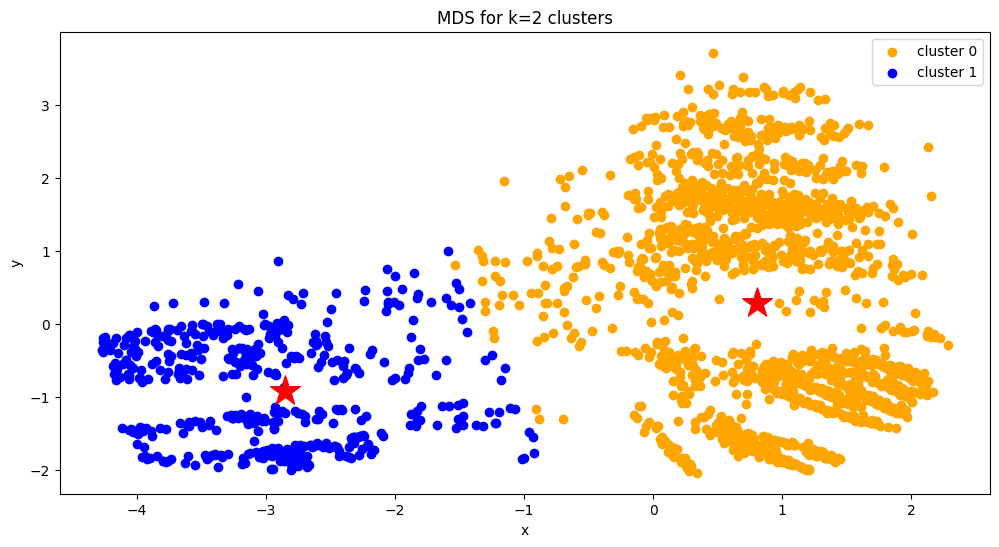

In [268]:
# Plotting the clusters
plt.figure(figsize=(12, 6))
k=2
ut.clustering_scatterplot(points=k2_XYcoordinates[:-k,:], 
                       labels=k2_clusters[0].labels_, 
                       centers=k2_XYcoordinates[-k:,:], 
                       title='MDS for k=2 clusters')

In [269]:
k2_XYcoordinates = manifold.TSNE(n_components=2).fit_transform(k2_data_and_centers)
print("transformation complete")

transformation complete


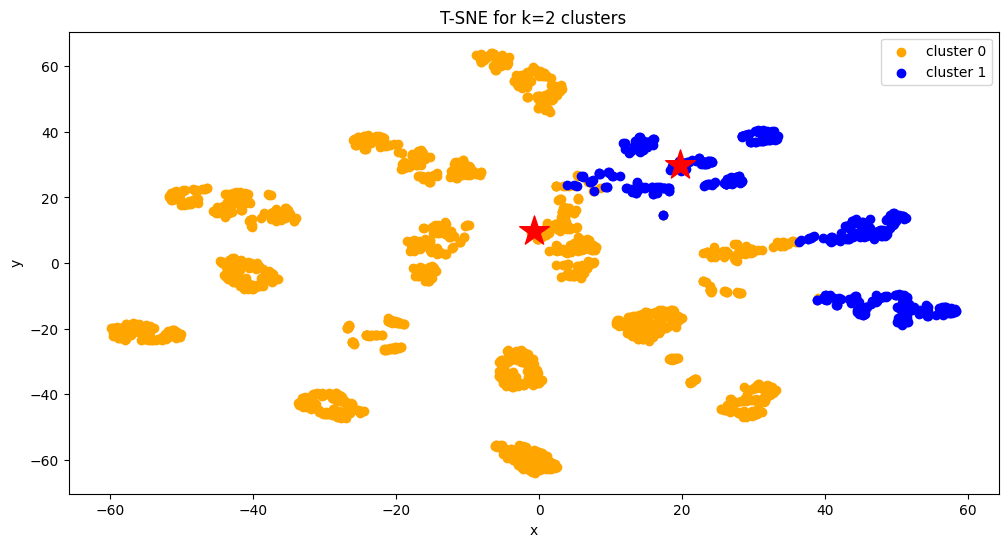

In [270]:
# Plotting the clusters
plt.figure(figsize=(12, 6))

k=2
ut.clustering_scatterplot(points=k2_XYcoordinates[:-k,:], 
                       labels=k2_clusters[0].labels_, 
                       centers=k2_XYcoordinates[-k:,:], 
                       title='T-SNE for k=2 clusters')

### Applying additional clustering algorithm

### Hierarchical clustering - K=2

In [271]:
# Hierarchical clustering
# linkage: {“ward”, “complete”, “average”, “single”}, default=”ward”
# The linkage criterion determines which distance to use between sets of observation.
# The algorithm will merge the pairs of cluster that minimize this criterion.

pipe_hierarchical = make_pipeline(cluster.AgglomerativeClustering(n_clusters=2, linkage='average'))
hierarchical_clusters = pipe_hierarchical.fit(df_scaled)

In [272]:
hierarchical_clusters[0].labels_

array([0, 0, 0, ..., 1, 1, 0])

In [273]:
## compute cluster centers  for hierarchical clustering

cluster_centers = np.zeros((2, df_scaled.shape[1]))

for i in range(2):
    cluster_centers[i] = df_scaled[hierarchical_clusters[0].labels_ == i].mean(axis=0)

cluster_centers

array([[ 0.4514644 ,  0.38429826,  0.13163975,  0.7498965 , -0.35012147,
        -0.11144275,  0.20713464,  0.15247411,  0.10989643,  0.0972382 ,
         0.16455696,  0.16168009,  0.14729574],
       [-0.01684446, -0.5017768 ,  3.76765572,  0.02105921,  0.32952373,
         0.4089233 ,  0.53982301,  0.11061947,  0.24115044,  0.29867257,
         0.0619469 ,  0.10176991,  0.09070796]])

In [274]:
# MDS
hierarchical_data_and_centers = np.r_[df_scaled, cluster_centers]

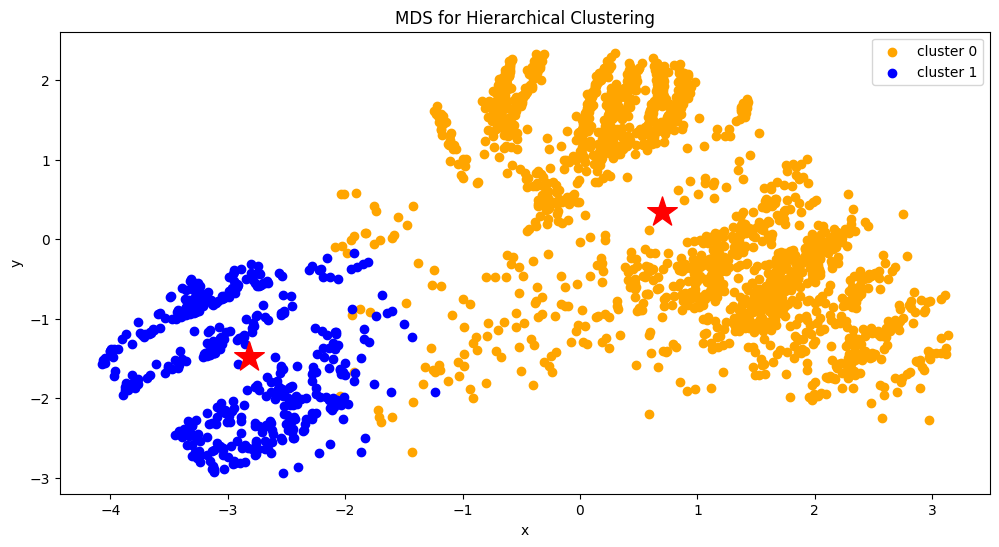

In [275]:
# visualize the clusters
XYcoordinates = manifold.MDS(n_components=2).fit_transform(hierarchical_data_and_centers)

plt.figure(figsize=(12, 6))
k=2
ut.clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=hierarchical_clusters[0].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS for Hierarchical Clustering')

### verifying Hierarchical clustering

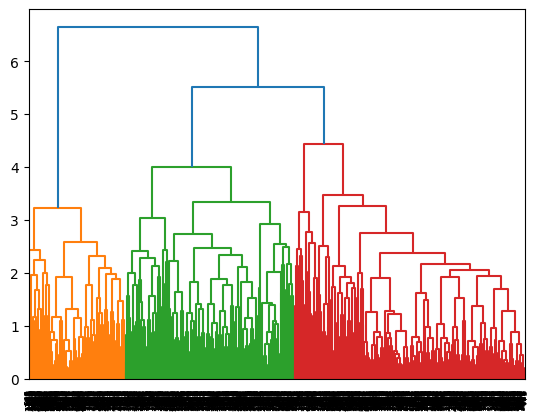

In [276]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram

mergings = hierarchy.linkage(df_scaled, method='complete', metric='euclidean')

dendrogram(mergings, labels=df_scaled.index, leaf_rotation=90, leaf_font_size=6)

plt.show()

### Observation 
- We observe a discrepency between optimal number of clusters and visual interpretation of a dendrogram


### Cluster Analysis

In [277]:
# cluster analysis 
df_scaled['cluster'] = k2_clusters[0].labels_

In [278]:
df_scaled.head()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,NSM,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,cluster
0,-0.055136,-0.022002,0.000000,0.0,-0.737075,-0.791667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.090582,-0.088238,0.000000,0.0,-0.661852,-0.645833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.090582,-0.114395,0.000000,0.0,-0.566321,-0.520833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.064784,-0.514621,3.717580,0.0,0.335216,-0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.059934,-0.514621,3.848314,0.0,0.335216,-0.125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [279]:
cluster_results = df_scaled.groupby('cluster').mean()
cluster_results

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,NSM,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
cluster,,,,,,,,,,,,,
0,0.454729,0.410948,0.061139,0.762066,-0.372459,-0.125508,0.202735,0.155172,0.111772,0.090963,0.162901,0.162901,0.148633
1,0.023973,-0.492337,3.600264,0.061111,0.328561,0.398130,0.517717,0.106299,0.220472,0.297244,0.078740,0.104331,0.092520


<Axes: >

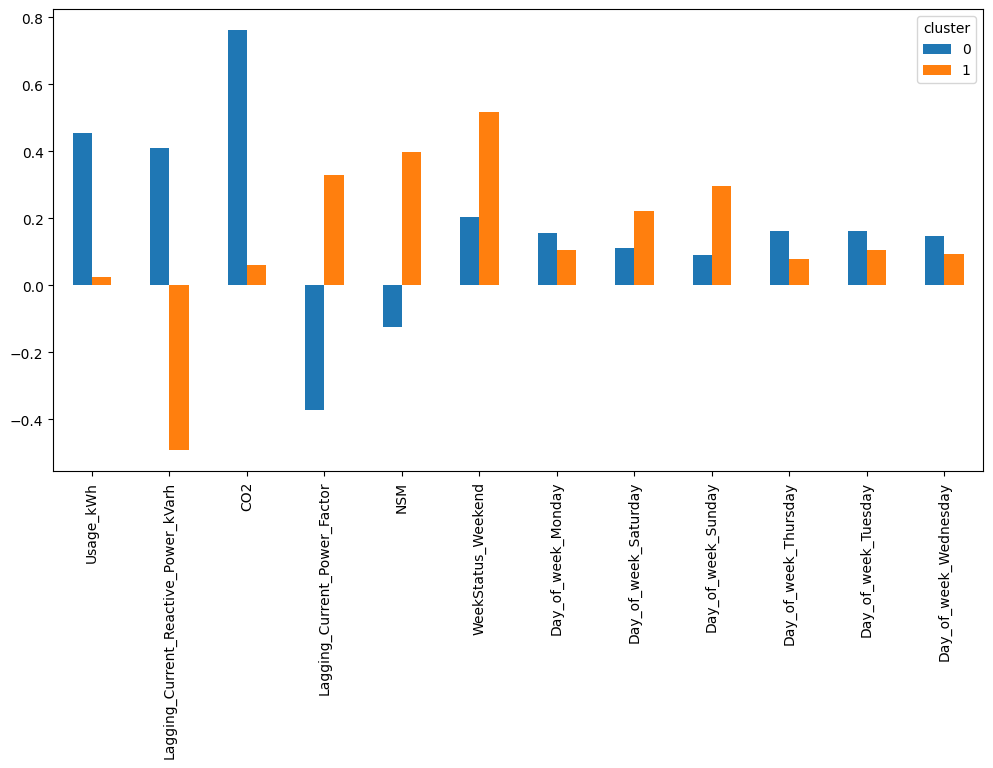

In [281]:
# exclude the cluster 'Leading_Current_Reactive_Power_kVarh	'ArithmeticError
cluster_results = cluster_results.drop(['Leading_Current_Reactive_Power_kVarh'], axis=1)

# plot the cluster results



cluster_results.T.plot(kind='bar', figsize=(12, 6))

### Observation

- More CO2 Emissions is found during steel plant operational
- Low electrical consumptions on weekends
- Steel plant were operational on most of the weekdays.

